<a href="https://colab.research.google.com/github/ChiNonsoHenry16/ChiNonsoHenry16/blob/main/Case_3_(7)_Online_Education_Assistant_With_Explainability%20Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementation of Case Study 157 for Graphic Results

In [1]:
!pip install lime shap gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.6 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=70cfc48623554c07925f836af74899af051ac0f8143d777cbe77273f537ada61
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import lime
from lime import lime_tabular
import shap
import gradio as gr

In [3]:
# Step 1: Data Simulation
def simulate_data(n=1000):
    np.random.seed(42)
    data = pd.DataFrame({
        'study_time': np.random.normal(10, 2, n),  # Study time in hours
        'online_activities': np.random.randint(1, 5, n),  # Participation in online activities
        'quiz_scores': np.random.normal(70, 10, n),  # Quiz scores percentage
        'content_interactions': np.random.randint(1, 10, n),  # Number of interactions
        'tutor_feedback': np.random.normal(3, 1, n),  # Tutor feedback (scale 1-5)
        'performance_history': np.random.normal(70, 10, n)  # General performance history percentage
    })

    # Academic performance category (0 = below 60%, 1 = 60-80%, 2 = above 80%)
    conditions = [
        (data['performance_history'] < 60),
        (data['performance_history'] >= 60) & (data['performance_history'] < 80),
        (data['performance_history'] >= 80)
    ]
    choices = [0, 1, 2]
    data['performance_category'] = np.select(conditions, choices, default=2)

    return data

data = simulate_data()

In [4]:
# Step 2: Data Preparation
X = data.drop('performance_category', axis=1)
y = data['performance_category']

#Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler

# Normalizing the features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [5]:
# Step 3: Model Creation
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [6]:
def lime_explanation(instance):
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=np.array(X_train),
        feature_names=X_train.columns,
        class_names=['Below 60%', '60-80%', 'Above 80%'],
        mode='classification'
    )
    explanation = explainer.explain_instance(
        data_row=instance,
        predict_fn=model.predict_proba
    )

    # Generate the LIME plot as a figure
    fig = explanation.as_pyplot_figure()

    # Save the figure to a file
    lime_plot_path = "lime_explanation_plot.png"
    fig.savefig(lime_plot_path)
    plt.close(fig)  # Close the plot to avoid display issues

    return lime_plot_path

In [7]:
def shap_explanation(instance):
    explainer = shap.TreeExplainer(model)

    # Convert instance to the correct format
    instance_scaled = scaler.transform(instance)
    instance_df = pd.DataFrame(instance_scaled, columns=X.columns)

    # Compute SHAP values
    shap_values = explainer.shap_values(instance_df)

    # Plot SHAP summary plot
    plt.figure()
    shap.summary_plot(shap_values, instance_df, plot_type="bar", show=False)

    # Save the plot to a file
    plt.savefig("shap_summary_plot.png")
    plt.close()

    return "shap_summary_plot.png"

In [8]:
def predict_and_explain(study_time, online_activities, quiz_scores, content_interactions, tutor_feedback, explanation_method):
    # Compute performance_history differently if required
    performance_history = (study_time + quiz_scores + tutor_feedback) / 3

    # Create instance with performance_history
    instance = pd.DataFrame([[
        study_time, online_activities, quiz_scores, content_interactions, tutor_feedback, performance_history
    ]], columns=X.columns)

    # Normalize the instance
    instance_scaled = pd.DataFrame(scaler.transform(instance), columns=X.columns)

    # Make prediction
    pred = model.predict(instance_scaled)[0]

    # Generate explanation
    if explanation_method == "LIME":
        lime_plot_path = lime_explanation(instance_scaled.iloc[0])
        return f"Prediction: {['Below 60%', '60-80%', 'Above 80%'][pred]}", lime_plot_path

    elif explanation_method == "SHAP":
        shap_plot_path = shap_explanation(instance_scaled)
        return f"Prediction: {['Below 60%', '60-80%', 'Above 80%'][pred]}", shap_plot_path

In [9]:
# Gradio Interface Function
def gradio_interface(study_time, online_activities, quiz_scores, content_interactions, tutor_feedback, explanation_method):
    try:
        prediction, explanation_output = predict_and_explain(
            study_time, online_activities, quiz_scores, content_interactions, tutor_feedback, explanation_method)
        if explanation_method == "LIME":
            return prediction, explanation_output  # Return the figure for LIME
        elif explanation_method == "SHAP":
            return prediction, explanation_output  # Return the image path for SHAP
    except Exception as e:
        return f"An error occurred: {str(e)}", None

interface = gr.Interface(
    fn=gradio_interface,
    inputs=[
        gr.Slider(minimum=0, maximum=20, value=8, label="Study Time (hours)"),
        gr.Slider(minimum=0, maximum=10, value=3, label="Online Activities"),
        gr.Slider(minimum=0, maximum=100, value=65, label="Quiz Scores (%)"),
        gr.Slider(minimum=0, maximum=10, value=7, label="Content Interactions"),
        gr.Slider(minimum=1, maximum=5, value=4, label="Tutor Feedback (scale 1-5)"),
        gr.Radio(choices=["LIME", "SHAP"], label="Explanation Method")
    ],
    outputs=["text", gr.Image(type="filepath")]  # Use "filepath" as the type for image output
)

# Launch the interface
interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b020922ebf3abec13c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


The Online Education Assistant App Deployed with Gradio and Explainability Techniques (LIME & SHAP)

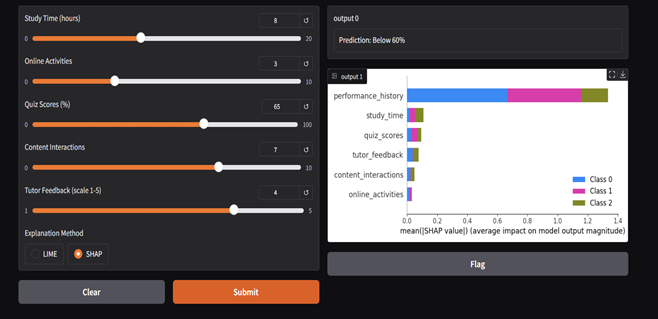